In [1]:
import os
import json
import numpy as np
from utils import data_utils
import matplotlib.pyplot as plt
from torchvision.io import read_image
from copy import deepcopy
import datasets

In [2]:
fashion_prefab_path="./simmc2/data/fashion_prefab_metadata_all.json"
furniture_prefab_path="./simmc2/data/furniture_prefab_metadata_all.json"

fashion_prefab = json.loads(open(fashion_prefab_path).read())
furniture_prefab = json.loads(open(furniture_prefab_path).read())

In [3]:
cats = data_utils.load_categories() # Category Dict
cats

{'categories': [{'supercategory': 'fashion', 'id': 0, 'name': 'jeans'},
  {'supercategory': 'fashion', 'id': 1, 'name': 'hat'},
  {'supercategory': 'fashion', 'id': 2, 'name': 'tank top'},
  {'supercategory': 'fashion', 'id': 3, 'name': 'hoodie'},
  {'supercategory': 'fashion', 'id': 4, 'name': 'shoes'},
  {'supercategory': 'fashion', 'id': 5, 'name': 'trousers'},
  {'supercategory': 'fashion', 'id': 6, 'name': 'vest'},
  {'supercategory': 'fashion', 'id': 7, 'name': 'coat'},
  {'supercategory': 'fashion', 'id': 8, 'name': 'dress'},
  {'supercategory': 'fashion', 'id': 9, 'name': 'shirt, vest'},
  {'supercategory': 'fashion', 'id': 10, 'name': 'blouse'},
  {'supercategory': 'fashion', 'id': 11, 'name': 'tshirt'},
  {'supercategory': 'fashion', 'id': 12, 'name': 'sweater'},
  {'supercategory': 'fashion', 'id': 13, 'name': 'shirt'},
  {'supercategory': 'fashion', 'id': 14, 'name': 'skirt'},
  {'supercategory': 'fashion', 'id': 15, 'name': 'joggers'},
  {'supercategory': 'fashion', 'id': 

In [4]:

data_path = './preprocessed_data/coref_candidates|no_mm/simmc2.1_coref_candidates_dstc11_train.json'
img_dir_paths = [
    './simmc2/data/simmc2_scene_images_dstc10_public_part1',
    './simmc2/data/simmc2_scene_images_dstc10_public_part2'
]

def load_image_text_eval_dataset(
    num_utterances = 3,
    scene_dir_path = "./simmc2/data/public", 
    data_path = data_path,
    img_dir_paths = img_dir_paths,
):
    with open(data_path, "r") as file_id:
        raw_data = json.load(file_id)    
        source_data = json.load(open(raw_data['source_path'],'r'))
    data = raw_data["data"]
    gt_data = source_data
    
    dset = {
        'utterance_id': [], 'object_id': [],
        'text': [], 'image': [], 'bbox': []
    }
    for row in data:
        # Dialogue idx to labels
        dialog_id = row['dialog_id']
        turn_id = row['turn_id']
        labels = row['ambiguous_candidates']

        # Scene
        scene_path = row['image_name'].replace('.png','_scene.json')
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"

        scene = json.load(open(scene_path, 'r'))
        scene_dict = {}
        for scene_objects in scene['scenes']:
            for obj in scene_objects['objects']:
                scene_dict[obj['unique_id']] = obj['bbox']

        image_path = row['image_name']
        for img_dir_path in img_dir_paths:
            if os.path.exists(f'{img_dir_path}/{image_path}'):
                image_path = f'{img_dir_path}/{image_path}'
                break

        dialogue = deepcopy(data[0]["input_text"])
        for turn_id, turn in enumerate(dialogue):
            if turn_id % 2 == 0:
                dialogue[turn_id] = "<USER> " + turn
            else:
                dialogue[turn_id] = "<SYS> " + turn
        text = " ".join(dialogue[-num_utterances:])

        for obj_id, bbox in scene_dict.items():
            dset['utterance_id'].append(f'{dialog_id}_{turn_id}') # utterance_id = {dialog_id}_{turn_id}
            dset['object_id'].append(obj_id)
            dset['text'].append(text)
            dset['image'].append(image_path)
            dset['bbox'].append(bbox)
    eval_dset = datasets.Dataset.from_dict(dset)
    eval_dset = eval_dset.cast_column("image", datasets.Image(decode=True))
    
    return eval_dset, gt_data, raw_data

In [5]:
with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)    
    source_data = json.load(open(raw_data['source_path'],'r'))
data = raw_data["data"]
gt_data = source_data['dialogue_data']

In [6]:
for row in raw_data['data']:
    if row['dialog_id'] == 1422 and row['turn_id'] == 1:
        break

In [7]:

scene_dir_path = "./simmc2/data/public"

In [8]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

def show_dialogue(dialogue_data):
    utterances = []
    for turn_id, turn in enumerate(dialogue_data['input_text']):
        if turn_id % 2 == 0:
            utterances.append("U: " + turn)
        else:
            utterances.append("S: " + turn)
    print("\n".join(utterances))

def show_image(dialogue_data, draw_bbox=True, img_dir_paths=img_dir_paths):
    image_path = dialogue_data['image_name']
    for img_dir_path in img_dir_paths:
        if os.path.exists(f'{img_dir_path}/{image_path}'):
            image_path = f'{img_dir_path}/{image_path}'
            break
    image = Image.open(image_path).convert("RGB")
    
    if draw_bbox:
        scene_path = dialogue_data['image_name'].replace('.png','_scene.json')
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"
        scene = json.load(open(scene_path, 'r'))
        object_map = dialogue_data['object_map']

        scene_objects = scene['scenes'][0]['objects']
        index_map = {obj['index']: obj_id for obj_id, obj in zip(object_map, scene_objects)}
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype("fonts/ArialTh.ttf", 40)
        for obj in scene_objects:
            if index_map[obj['index']] in dialogue_data['ambiguous_candidates']:
                bbox, prefab = obj['bbox'], obj['prefab_path']
                if prefab in furniture_prefab:
                    name = furniture_prefab[prefab]['type']
                else: # Fashion
                    name = fashion_prefab[prefab]['assetType']

                for i in range(-2, 3):
                    draw.rectangle(((bbox[0] + i, bbox[1] + i), (bbox[0] + i + bbox[3], bbox[1] + bbox[2] + i)), outline="red")
                draw.text((bbox[0], max(0, bbox[1]-40)), name, fill='red', font=font)
                print(((bbox[0], bbox[1]), (bbox[0] + bbox[3], bbox[1] + bbox[2])))
    plt.imshow(image)

In [9]:
print(raw_data["data"][0])
len(raw_data["data"])

{'dialog_id': 12304, 'turn_id': 0, 'input_text': ['Hi, do you have any jackets today?'], 'ambiguous_candidates': [82, 58, 59], 'image_name': 'cloth_store_1498649_woman_5_3.png', 'object_map': [59, 80, 55, 67, 68, 70, 82, 79, 69, 72, 71, 73, 61, 62, 63, 58, 74, 75, 64, 76]}


38127

In [10]:
blank_counter = 0
for i in range(len(raw_data["data"])):
    if raw_data["data"][i]["ambiguous_candidates"] == []:
        blank_counter += 1
    else:
        print(i, raw_data["data"][i]["ambiguous_candidates"])
print(blank_counter)

0 [82, 58, 59]
1 [59, 82]
2 [55]
3 [82]
5 [4]
6 [4]
8 [1, 2]
9 [5]
12 [1, 2]
14 [8, 1]
15 [2, 8, 6]
18 [56]
20 [64, 63]
21 [68, 55]
23 [63, 68]
24 [16]
25 [55]
27 [16]
28 [0, 7]
29 [7]
30 [7]
32 [2, 8]
33 [8]
34 [8, 2, 1]
37 [7]
38 [2, 6, 1]
40 [2]
41 [3]
43 [11]
44 [85]
45 [85]
47 [62, 63, 64]
49 [63]
50 [65, 70, 80]
51 [70, 80]
53 [64, 63]
54 [10]
55 [11]
56 [15, 41]
58 [40, 41]
59 [83]
60 [31, 35, 46]
61 [36, 83]
63 [53, 58, 82]
65 [58, 82]
66 [58]
68 [26, 53]
69 [10]
70 [83]
71 [83]
72 [21, 34]
74 [83]
75 [39, 27, 15]
77 [16, 67]
78 [81]
79 [38]
80 [51, 22]
82 [51, 22]
83 [23]
84 [26, 27, 39]
85 [67]
86 [61]
88 [62, 63]
89 [62, 63]
90 [62, 63]
91 [19, 31]
93 [18, 49]
94 [18, 49]
95 [2, 8, 6]
96 [8, 6]
98 [6, 58]
99 [2]
100 [3]
102 [3]
103 [0, 7]
104 [11, 28, 29]
107 [11]
110 [58, 59, 55]
112 [29, 28]
113 [68]
114 [78, 51, 73]
115 [51, 50]
117 [51]
118 [68]
119 [51, 50]
120 [4]
121 [2, 6]
122 [6, 8, 1]
124 [59, 55]
127 [70]
128 [59, 55]
129 [59, 55]
130 [9, 51]
132 [51]
133 [39, 26,

In [11]:
def load_image_conv_dataset(
    scene_dir_path = "./simmc2/data/public", 
    data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json',
    img_dir_paths = [
        './simmc2/data/simmc2_scene_images_dstc10_public_part1',
        './simmc2/data/simmc2_scene_images_dstc10_public_part2'
    ],
    return_gt_labels=True,
):
    with open(data_path, "r") as file_id:
        raw_data = json.load(file_id)    
    data = raw_data["data"]
    gold_data = json.load(open(raw_data['source_path'],'r'))
    
    dset = {
        'dialog_id': [], 'scene_id': [], 'turn_id': [], 'object_id': [],
        'prefab_object_id': [], 'other_ambig_object_unique_ids': [],
        'dialogue': [], 'image': [], 'bbox': []
    }
    
    for row_id, row in enumerate(data):
        # Dialogue idx to labels
        dialog_id = row['dialog_id']
        turn_id = row['turn_id']
        labels = row['ambiguous_candidates']
        object_map = row['object_map']

        # Scene
        scene_path = row['image_name'].replace('.png','_scene.json')
        scene_id = row['image_name'].split(".")[0]
        if os.path.exists(f"{scene_dir_path}/{scene_path}"):
            scene_path = f"{scene_dir_path}/{scene_path}"
        elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
            scene_path = f"{scene_dir_path}/m_{scene_path}"

        scene = json.load(open(scene_path, 'r'))
        scene_dict = {}

        

        for scene_objects in scene['scenes']:
            
            index_mapping = {obj['index']: local_object_id \
                for local_object_id, obj in zip(object_map, scene_objects['objects'])}
            local_to_prefab_index_mapping = {local_object_id: obj['unique_id'] \
                for local_object_id, obj in zip(object_map, scene_objects['objects'])}

            for obj in scene_objects['objects']:
                local_object_id = index_mapping[obj['index']]
                if local_object_id in labels: # ambigous conv-image pair
                    other_ambig_object_ids = labels.copy()
                    other_ambig_object_ids.remove(local_object_id)

                    other_ambig_object_unique_ids = []
                    for local_id in other_ambig_object_ids:
                        if local_id in local_to_prefab_index_mapping:
                            other_ambig_object_unique_ids.append(local_to_prefab_index_mapping[local_id])
                        else:
                            other_ambig_object_unique_ids.append(local_id)
                            
                    scene_dict[index_mapping[obj['index']]] = (obj['bbox'], obj['unique_id'], other_ambig_object_unique_ids)
                
                # if dialog_id == 11496:
                #     print(dialog_id, turn_id, obj_id, other_ambig_object_unique_ids, dialogue)

        image_path = row['image_name']
        for img_dir_path in img_dir_paths:
            if os.path.exists(f'{img_dir_path}/{image_path}'):
                image_path = f'{img_dir_path}/{image_path}'
                break

        dialogue = row["input_text"]
        for obj_id, (bbox, prefab_obj_id, other_ambig_object_unique_ids) in scene_dict.items():
            dset['dialog_id'].append(dialog_id)
            dset['scene_id'].append(scene_id)
            dset['turn_id'].append(turn_id)
            dset['object_id'].append(obj_id)
            dset['prefab_object_id'].append(prefab_obj_id)
            dset['other_ambig_object_unique_ids'].append(other_ambig_object_unique_ids)
            dset['dialogue'].append(dialogue)
            dset['image'].append(image_path)
            dset['bbox'].append(bbox)
            
    eval_dset = datasets.Dataset.from_dict(dset)
    eval_dset = eval_dset.cast_column("image", datasets.Image(decode=True))
    
    if return_gt_labels:
        return eval_dset, gold_data
    else:
        return eval_dset

In [14]:
from utils import data_utils
from torchvision.transforms import (
    CenterCrop,
    ColorJitter,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    RandomResizedCrop,
    RandomRotation,
    Resize,
    ToTensor,
)
import transformers

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")


eval_dset, gold_data = data_utils.load_image_conv_dataset(
    data_path="/home/holy/projects/ambiguous-mm-dialogue/preprocessed_data/coref_candidates|no_mm/simmc2.1_coref_candidates_dstc11_train.json",
    return_gt_labels=True)
gold_data_pool = {ii["dialogue_idx"]: ii for ii in gold_data["dialogue_data"]}


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
eval_transforms = Compose(
    [
        Resize(feature_extractor.size),
        # CenterCrop(feature_extractor.size),
        # ToTensor(),
        # normalize,
    ]
)

def eval_image_preprocess(example_batch):            
    images = [
        eval_transforms(
            image.convert("RGB").crop((
                bbox[0], bbox[1], bbox[0]+max(5, bbox[3]), bbox[1]+max(5, bbox[2])
            ))
        )
        for image, bbox in zip(example_batch["image"], example_batch["bbox"])
    ]
    example_batch["object_image"] = images
    example_batch["pixel_values"] = feature_extractor(
        images=images, text="", return_tensors="pt")["pixel_values"]
    return example_batch

eval_dset = eval_dset.with_transform(eval_image_preprocess)
print(len(eval_dset))

48834


gt {'turn_idx': 4, 'system_transcript': 'Unfortunately, my search for similar pants has no results. Can I help you search for anything else?', 'system_transcript_annotated': {'act': 'INFORM:GET', 'act_attributes': {'slot_values': {}, 'request_slots': [], 'objects': []}}, 'transcript': 'Sounds good! One more question: what pants do you have available in the same sizes as the grey pair by the door but in a green color?', 'transcript_annotated': {'act': 'INFORM:GET', 'act_attributes': {'slot_values': {'color': 'green', 'availableSizes': ['XS'], 'type': 'trousers'}, 'request_slots': ['availableSizes'], 'objects': [10]}, 'disambiguation_label': 0, 'disambiguation_candidates': [], 'disambiguation_candidates_raw': []}}

{'dialog_id': 12010, 'scene_id': 'cloth_store_1416238_woman_20_3', 'turn_id': 4, 'object_id': 10, 'prefab_object_id': 9, 'other_ambig_object_unique_ids': [], 'dialogue': ['I would like to find a blouse in a large size that has positive customer ratings.', 'I have three blouses

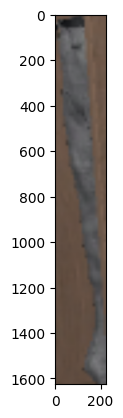

In [96]:
import matplotlib.pyplot as plt
index = 500
# print(meta_dset[index])
# print()
print("gt", gold_data_pool[eval_dset[index]["dialog_id"]]["dialogue"][eval_dset[index]["turn_id"]]) #["transcript_annotated"]["disambiguation_candidates"])
print()
print(eval_dset[index])
print()
plt.imshow(eval_transforms(eval_dset[index]["image"].convert("RGB").crop((
    eval_dset[index]['bbox'][0],
    eval_dset[index]['bbox'][1],
    eval_dset[index]['bbox'][0] + max(5, eval_dset[index]['bbox'][3]),
    eval_dset[index]['bbox'][1] + max(5, eval_dset[index]['bbox'][2]),
))))


U: I need a new blouse.
S: Ok, what do you think of these? I have a black blouse in the bottom center of the wall display, another black blouse directly above it, and a white and black blouse to the right of that.
U: Those aren't bad. I'd like something kinda like those two on the top in terms of display and available sizes, but more expensive and with reviews to match.
S: I'm sorry, I don't have anything like that at the moment. Could I help you with something else?
U: Yeah, go ahead and add that white and black blouse to my cart, would you?

((793, 1), (1050, 329))


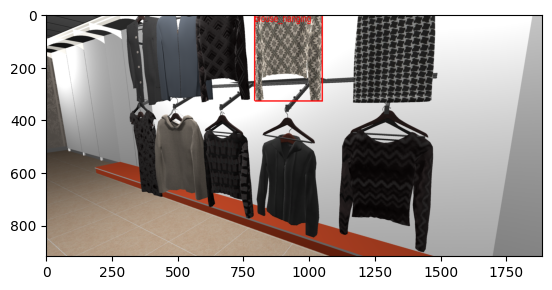

In [ ]:
index = 40
show_dialogue(raw_data['data'][index])
print()
show_image(raw_data['data'][index])

In [11]:
scene_path = row['image_name'].replace('.png','_scene.json')

if os.path.exists(f"{scene_dir_path}/{scene_path}"):
    scene_path = f"{scene_dir_path}/{scene_path}"
elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
    scene_path = f"{scene_dir_path}/m_{scene_path}"
scene = json.load(open(scene_path, 'r'))

NameError: name 'row' is not defined

In [12]:
scene['scenes'][0]['objects']

NameError: name 'scene' is not defined

In [13]:
gt_data['dialogue_data'][0]['dialogue_idx'], gt_data['dialogue_data'][0]['dialogue'][0]['turn_idx']
gt_data['dialogue_data'][0]['dialogue'][6]['transcript_annotated']['disambiguation_candidates']

NameError: name 'gt_data' is not defined

In [12]:
data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json'
with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)
data = raw_data["data"]

In [ ]:
import pandas as pd

In [41]:
df= pd.DataFrame({'d': [1,1,1,2,2,2], 't': [1,1,2,1,2,2], 'p': [1,2,3,4,5,6]})
df.groupby(['d','t'])['p'].apply(list).reset_index().to_dict('records')

[{'d': 1, 't': 1, 'p': [1, 2]},
 {'d': 1, 't': 2, 'p': [3]},
 {'d': 2, 't': 1, 'p': [4]},
 {'d': 2, 't': 2, 'p': [5, 6]}]

In [15]:
num_utterances = 3
scene_dir_path = "./simmc2/data/public"
data_path = './preprocessed_data/ambiguous_candidates/simmc2.1_ambiguous_candidates_dstc11_devtest.json'
img_dir_paths = [
    './simmc2/data/simmc2_scene_images_dstc10_public_part1',
    './simmc2/data/simmc2_scene_images_dstc10_public_part2'
]

with open(data_path, "r") as file_id:
    raw_data = json.load(file_id)    
    source_data = json.load(open(raw_data['source_path'],'r'))
data = raw_data["data"]
gt_data = source_data['dialogue_data']

dset = {
    'utterance_id': [], 'object_id': [],
    'text': [], 'image': [], 'bbox': []
}

for row in data:
    # Dialogue idx to labels
    dialog_id = row['dialog_id']
    turn_id = row['turn_id']
    labels = row['ambiguous_candidates']

    if not (dialog_id == 10912 and turn_id == 8):
        continue

    # Scene
    scene_path = row['image_name'].replace('.png','_scene.json')
    if os.path.exists(f"{scene_dir_path}/{scene_path}"):
        scene_path = f"{scene_dir_path}/{scene_path}"
    elif os.path.exists(f"{scene_dir_path}/m_{scene_path}"):
        scene_path = f"{scene_dir_path}/m_{scene_path}"

    scene = json.load(open(scene_path, 'r'))
    scene_dict = {}
    for scene_objects in scene['scenes']:
        for obj in scene_objects['objects']:
            scene_dict[obj['unique_id']] = obj['bbox']

    image_path = data[0]['image_name']
    for img_dir_path in img_dir_paths:
        if os.path.exists(f'{img_dir_path}/{image_path}'):
            image_path = f'{img_dir_path}/{image_path}'
            break

    dialogue = deepcopy(data[0]["input_text"])
    for turn_id, turn in enumerate(dialogue):
        if turn_id % 2 == 0:
            dialogue[turn_id] = "<USER> " + turn
        else:
            dialogue[turn_id] = "<SYS> " + turn
    text = " ".join(dialogue[-num_utterances:])
    break

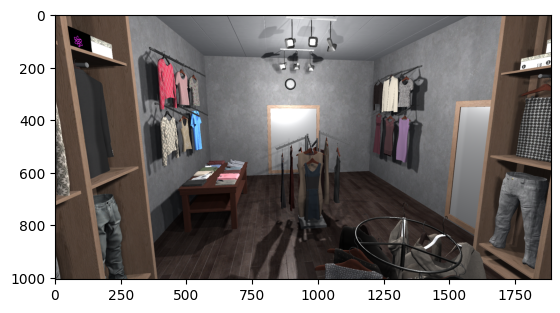

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open(image_path).convert('RGB'))

In [ ]:
np.array(Image.open(image_path).convert('RGB')).shape

(1005, 1886, 3)

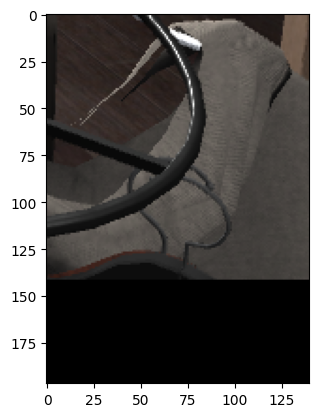

In [ ]:
plt.imshow(Image.open(image_path).convert('RGB').crop([1461, 863, 1461+140, 863+197]))

{'objects': [{'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_2_03',
   'unique_id': 0,
   'index': 4,
   'bbox': [1116, 378, 33, 18],
   'position': [-1.8927173614501953,
    -1.3044729232788086,
    0.14418506622314453]},
  {'prefab_path': 'WomensCollection/Prefabs/Rearranged/blouse_2_15',
   'unique_id': 1,
   'index': 56,
   'bbox': [29, 450, 136, 27],
   'position': [-2.9001598358154297, 1.8430695533752441, -2.214702844619751]},
  {'prefab_path': 'WomensCollection/Prefabs/Rearranged/blouse_01_62',
   'unique_id': 2,
   'index': 57,
   'bbox': [129, 463, 106, 52],
   'position': [-3.68367862701416, 1.8414487838745117, -2.2199110984802246]},
  {'prefab_path': '870230/hoodie04',
   'unique_id': 3,
   'index': 58,
   'bbox': [198, 437, 129, 41],
   'position': [-4.290022373199463, 2.065037488937378, -2.2163619995117188]},
  {'prefab_path': 'MensCollection/Prefabs/Rearranged/jacket_2_06',
   'unique_id': 4,
   'index': 59,
   'bbox': [198, 449, 128, 28],
   'position': [-5.896

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel, VisionTextDualEncoderModel, VisionTextDualEncoderProcessor

model = VisionTextDualEncoderModel.from_pretrained("./save/text-im-align/CLIP__last/vit-base-patch32__roberta-base")
processor = VisionTextDualEncoderProcessor.from_pretrained("./save/text-im-align/CLIP__last/vit-base-patch32__roberta-base")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url_2 = "https://onlinejpgtools.com/images/examples-onlinejpgtools/sunflower.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image_2 = Image.open(requests.get(url_2, stream=True).raw)

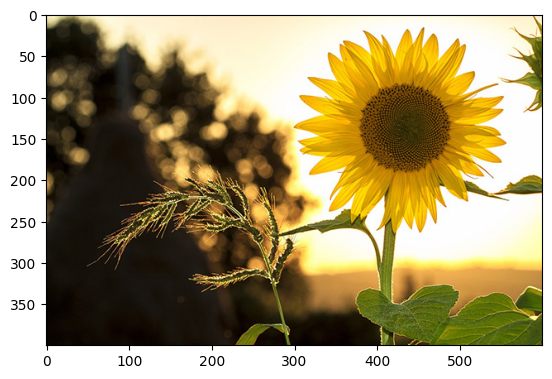

In [ ]:
plt.imshow(image_2)

In [ ]:
inputs = processor(text=["I want to get that cat"], images=[image, image_2, image], return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

outputs

CLIPOutput(loss=None, logits_per_image=tensor([[15.4830],
        [15.4832],
        [15.4830]], grad_fn=<PermuteBackward0>), logits_per_text=tensor([[15.4830, 15.4832, 15.4830]], grad_fn=<MulBackward0>), text_embeds=tensor([[ 4.0531e-02, -3.5118e-02,  5.4270e-02,  1.5643e-02,  1.1779e-02,
          7.2287e-02,  2.9793e-02, -2.4442e-02, -4.2052e-02,  2.5055e-02,
         -6.6999e-02, -5.2777e-02,  6.2316e-02, -1.9657e-02, -4.8642e-02,
          1.7774e-02, -6.4834e-02, -3.2161e-02, -1.0373e-02, -2.6806e-03,
         -9.5809e-02, -2.0541e-02,  3.7419e-02,  7.0741e-03, -3.9970e-02,
         -9.4345e-02, -4.7105e-02,  6.6801e-02, -5.2718e-02,  7.8980e-02,
         -5.3109e-03,  2.7226e-02,  1.0684e-02,  2.8160e-02,  6.1839e-02,
          4.8572e-02,  3.1276e-03,  3.5988e-02,  4.3280e-02, -9.3868e-02,
         -1.5002e-02, -5.9429e-02,  2.7115e-02, -4.0420e-02,  5.0762e-02,
          8.1964e-03,  1.0253e-01,  1.9053e-03,  7.6890e-02, -1.3554e-02,
         -3.5202e-02,  4.9118e-02,  1.2635e

In [ ]:
import torch
torch.cat([torch.eye(10), torch.eye(10) + 2, torch.eye(10) + 4]).T.numpy().diagonal()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
np.concatenate([np.ones(10), np.array([[]]).diagonal()])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
import pandas as pd
df = pd.DataFrame({'d':[1,1,1,1,2,2,2,2], 't':[1,1,2,2,1,1,2,2], 'o':[1,2,3,4,1,2,3,4], 'l':[0.5, 0.8, 0.3, 0.1, 0.7, 0.6, 0.2, 0.4]})

In [ ]:
df.groupby(['d', 't']).agg({'o': list, 'l': list}).reset_index()

,d,t,o,l
0,1,1,"[1, 2]","[0.5, 0.8]"
1,1,2,"[3, 4]","[0.3, 0.1]"
2,2,1,"[1, 2]","[0.7, 0.6]"
3,2,2,"[3, 4]","[0.2, 0.4]"


In [107]:
np.where(np.arange(10, 25, 1)>15)[]

[6, 7, 8, 9, 10, 11, 12, 13, 14]

In [349]:
task_list = [
    'indspeech_digit_cdsr_nusantara_sptext',
    'indspeech_news_lvcsr_nusantara_sptext',
    'indspeech_teldialog_lvcsr_nusantara_sptext',
    'indspeech_teldialog_svcsr_nusantara_sptext',
    'librivox_indonesia_ind_nusantara_sptext',
    'titml_idn_nusantara_sptext'
    'indspeech_newstra_ethnicsr_nooverlap_sun_nusantara_sptext',
    'indspeech_news_ethnicsr_su_nooverlap_nusantara_sptext',
    'librivox_indonesia_sun_nusantara_sptext',
    'su_id_asr_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_jav_nusantara_sptext',
    'indspeech_news_ethnicsr_jv_nooverlap_nusantara_sptext',
    'librivox_indonesia_jav_nusantara_sptext',
    'jv_id_asr_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_ban_nusantara_sptext',
    'librivox_indonesia_ban_nusantara_sptext',
    'indspeech_newstra_ethnicsr_nooverlap_btk_nusantara_sptext',
    'librivox_indonesia_ace_nusantara_sptext',
    'librivox_indonesia_bug_nusantara_sptext',
    'librivox_indonesia_min_nusantara_sptext',
]

In [352]:
for task in task_list:
    name = task.split('_nusantara_')[0]
    print(f"""
CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \\
   --task_config_name {task} \\
   --preprocessing_num_workers=16 --audio_column_name=audio --text_column_name=text \\
   --per_device_train_batch_size=16 --per_device_eval_batch_size=16 \\
   --dataloader_num_workers=16 --dataloader_pin_memory \\
   --seed=14045 --num_train_epochs=30 --learning_rate=5e-5 --fp16 \\
   --logging_strategy=steps --logging_steps=10 --report_to=tensorboard \\
   --evaluation_strategy=epoch --eval_steps=1 --eval_accumulation_steps=1 \\
   --save_strategy=epoch --save_steps=1 --save_total_limit=3 --load_best_model_at_end \\
   --metric_for_best_model=mer --greater_is_better=False \\
   --gradient_checkpointing=True \\
   --cache_dir=./cache/{name}/ \\
   --output_dir=./save/{name}/
    """)


CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \
   --task_config_name indspeech_digit_cdsr_nusantara_sptext \
   --preprocessing_num_workers=16 --audio_column_name=audio --text_column_name=text \
   --per_device_train_batch_size=16 --per_device_eval_batch_size=16 \
   --dataloader_num_workers=16 --dataloader_pin_memory \
   --seed=14045 --num_train_epochs=30 --learning_rate=5e-5 --fp16 \
   --logging_strategy=steps --logging_steps=10 --report_to=tensorboard \
   --evaluation_strategy=epoch --eval_steps=1 --eval_accumulation_steps=1 \
   --save_strategy=epoch --save_steps=1 --save_total_limit=3 --load_best_model_at_end \
   --metric_for_best_model=mer --greater_is_better=False \
   --gradient_checkpointing=True \
   --cache_dir=./cache/indspeech_digit_cdsr/ \
   --output_dir=./save/indspeech_digit_cdsr/
    

CUDA_VISIBLE_DEVICES=4 python src/train.py --model_name_or_path=facebook/wav2vec2-large-xlsr-53 \
   --task_config_name indspeech